In [ ]:
#import required libraries

import pathlib
import tensorflow as tfx
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/melanoma assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/melanoma assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [ ]:
#see image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

Create a dataset

Define some parameters for the loader:

In [ ]:
#Using 80% of the images for training, and 20% for validation.

batch_size = 32
img_height = 180
img_width = 180

In [ ]:
## creating train dataset
train_ds = tfx.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## creating validation dataset
val_ds = tfx.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# Listing out all the classes of skin cancer and store them in a list. 
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


Visualize the data

Todo, create a code to visualize one instance of all the nine classes present in the dataset

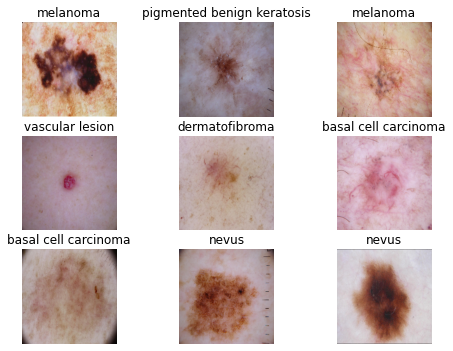

In [ ]:
### your code goes here, you can use training or validation data to visualize
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(8,8))
for images,labels in val_ds.take(1):
  for i in range (9):
    axes = plt.subplot(4,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.


In [ ]:
AUTOTUNE = tfx.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Create a CNN model, which can accurately detect 9 classes present in the dataset. 

In [ ]:
preprocess_layers = [
    tfx.keras.layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3))
    ]

In [ ]:
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D

input_shape=(180,180,3)
init='normal'
activation = 'relu'

model = Sequential()
model.add(tfx.keras.layers.experimental.preprocessing.Rescaling(1./255,input_shape=input_shape)) #rescaling

model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape)) #1st convolutional layer
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(64,kernel_size=(3,3),activation='relu')) #2nd convolutional layer
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(128,kernel_size=(3,3),activation='relu')) #3rd convolutional layer
model.add(MaxPool2D(pool_size=(2,2)))

model.add(layers.Flatten())

model.add(layers.Dense(128,activation='relu'))

model.add(layers.Dropout(0.5))

model.add(layers.Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrapp  (None, 178, 178, 32)     896       
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 89, 89, 32)       0         
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 87, 87, 64)       18496     
 pper)                                                           
                                                                 
 module_wrapper_3 (ModuleWra  (None, 43, 43, 64)       0         
 pper)                                                  

Compile the model

optimiser adam is used and cross entropy loss function for model training


In [ ]:
#optimiser and loss function
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrapp  (None, 178, 178, 32)     896       
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 89, 89, 32)       0         
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 87, 87, 64)       18496     
 pper)                                                           
                                                                 
 module_wrapper_3 (ModuleWra  (None, 43, 43, 64)       0         
 pper)                                                  

Train the model


In [ ]:
epochs = 20 #training model with 20 epochs

history = model.fit(
  train_ds,
  batch_size=32,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 274s 971ms/step - loss: -4783853.5000 - accuracy: 0.1724 - val_loss: -36911280.0000 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 2s 40ms/step - loss: -857615552.0000 - accuracy: 0.1724 - val_loss: -3482726400.0000 - val_accuracy: 0.1499
Epoch 3/20
56/56 [==============================] - 2s 40ms/step - loss: -17817346048.0000 - accuracy: 0.1724 - val_loss: -49954447360.0000 - val_accuracy: 0.1499
Epoch 4/20
56/56 [==============================] - 2s 40ms/step - loss: -141656571904.0000 - accuracy: 0.1724 - val_loss: -311589699584.0000 - val_accuracy: 0.1499
Epoch 5/20
56/56 [==============================] - 2s 40ms/step - loss: -665695092736.0000 - accuracy: 0.1724 - val_loss: -1239034494976.0000 - val_accuracy: 0.1499
Epoch 6/20
56/56 [==============================] - 2s 40ms/step - loss: -2180615503872.0000 - accuracy: 0.1724 - val_loss: -3662318927872.0000 - val_accuracy: 0.1499
Epoch 7/20
56/56 [==

Visualizing training results

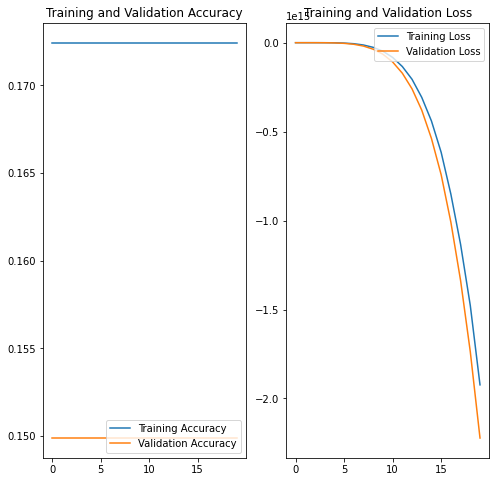

In [ ]:
#this step is to visualize the results of training from previous steps

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
accuracy_train = model.evaluate(train_ds)
accuracy_test = model.evaluate(val_ds)

14/14 [==============================] - 0s 17ms/step - loss: -2222567997833216.0000 - accuracy: 0.1499


Does the model underfit or overfit ?

In [20]:
print("validation accuracy: " ,accuracy_test)
print("training accuracy: ", accuracy_train)

validation accuracy:  [-2222567997833216.0, 0.14988814294338226]
training accuracy:  [-2166551826399232.0, 0.1724330335855484]


based on the accuracy observed from the training and validation datasets, the model is overfit.

In [21]:
image_data_gen = tfx.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    #zca_epsilon=1e-06,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.1,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    interpolation_order=1,
    dtype=None
)

In [22]:
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [23]:
training_batch = image_data_gen.flow_from_directory(data_dir_train,
                                                    target_size=(180,180),
                                                    classes = class_names,
                                                    batch_size=32
                                                    )

validation_batch = image_data_gen.flow_from_directory(data_dir_test,
                                                    target_size=(180,180),
                                                    classes = class_names,
                                                    batch_size=32
                                                    )

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


In [24]:
from tensorflow.keras.models import Sequential

import tensorflow as tfx

model = Sequential()

model.add(tfx.keras.layers.experimental.preprocessing.Rescaling(1./255,input_shape=input_shape)) #rescaling

#increase model size by another layer
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape)) #1st convolutional layer
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape))

model.add(MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.2))

model.add(Conv2D(64,kernel_size=(3,3),activation='relu')) #2nd convolutional layer
model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))

model.add(MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.4))

model.add(Conv2D(128,kernel_size=(3,3),activation='relu')) #3rd convolutional layer
model.add(MaxPool2D(pool_size=(2,2)))

model.add(layers.Dropout(0.4))

model.add(layers.Flatten()) #flatten layer

model.add(layers.Dense(512,activation='relu'))

model.add(layers.Dropout(0.5))

model.add(layers.Dense(9,activation='softmax')) #softmax activation layer

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_6 (ModuleWra  (None, 178, 178, 32)     896       
 pper)                                                           
                                                                 
 module_wrapper_7 (ModuleWra  (None, 176, 176, 32)     9248      
 pper)                                                           
                                                                 
 module_wrapper_8 (ModuleWra  (None, 88, 88, 32)       0         
 pper)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 88, 88, 32)        0         
                                                      

In [25]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_6 (ModuleWra  (None, 178, 178, 32)     896       
 pper)                                                           
                                                                 
 module_wrapper_7 (ModuleWra  (None, 176, 176, 32)     9248      
 pper)                                                           
                                                                 
 module_wrapper_8 (ModuleWra  (None, 88, 88, 32)       0         
 pper)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 88, 88, 32)        0         
                                                      

In [26]:
#training the model with new validation & training batches from previous steps

epochs = 20

history = model.fit(
  training_batch,
  batch_size=10,
  validation_data=validation_batch,
  epochs=epochs
)

Epoch 1/20
70/70 [==============================] - 97s 1s/step - loss: 0.3451 - accuracy: 0.2144 - val_loss: 0.3829 - val_accuracy: 0.2373
Epoch 2/20
70/70 [==============================] - 62s 883ms/step - loss: 0.3092 - accuracy: 0.3149 - val_loss: 0.3914 - val_accuracy: 0.3051
Epoch 3/20
70/70 [==============================] - 63s 896ms/step - loss: 0.2852 - accuracy: 0.3819 - val_loss: 0.3498 - val_accuracy: 0.3136
Epoch 4/20
70/70 [==============================] - 61s 875ms/step - loss: 0.2807 - accuracy: 0.4078 - val_loss: 0.3366 - val_accuracy: 0.2542
Epoch 5/20
70/70 [==============================] - 59s 847ms/step - loss: 0.2800 - accuracy: 0.4006 - val_loss: 0.3434 - val_accuracy: 0.3051
Epoch 6/20
70/70 [==============================] - 64s 919ms/step - loss: 0.2777 - accuracy: 0.4158 - val_loss: 0.3382 - val_accuracy: 0.3136
Epoch 7/20
70/70 [==============================] - 62s 886ms/step - loss: 0.2657 - accuracy: 0.4632 - val_loss: 0.3359 - val_accuracy: 0.3475
Ep

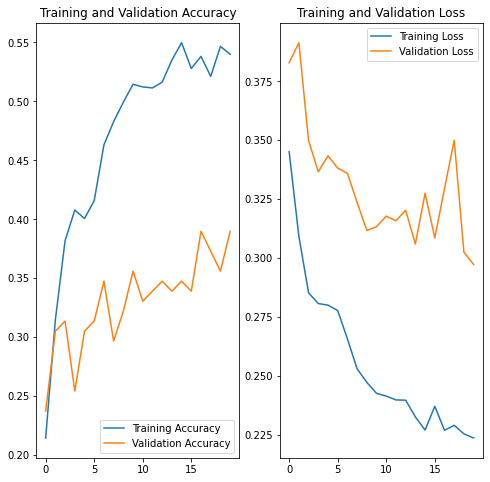

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
#accuracy_train = model.evaluate(train_ds)
#accuracy_test = model.evaluate(val_ds)

In [ ]:
for i in class_names

In [30]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
path_to_training_dataset="/content/gdrive/MyDrive/melanoma assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/melanoma assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0C62325A10>: 100%|██████████| 500/500 [00:23<00:00, 21.58 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/melanoma assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0C621AE4D0>: 100%|██████████| 500/500 [00:20<00:00, 24.96 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/melanoma assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0C62028150>: 100%|██████████| 500/500 [00:18<00:00, 26.56 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/melanoma assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F0C62356D10>: 100%|██████████| 500/500 [01:38<00:00,  5.10 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/melanoma assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0C621A6790>: 100%|██████████| 500/500 [01:26<00:00,  5.81 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/melanoma assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0C4C974BD0>: 100%|██████████| 500/500 [00:17<00:00, 28.22 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/melanoma assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F0C4C889750>: 100%|██████████| 500/500 [00:42<00:00, 11.72 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/melanoma assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0CB009C5D0>: 100%|██████████| 500/500 [00:18<00:00, 27.29 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/melanoma assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0C6231E650>: 100%|██████████| 500/500 [00:18<00:00, 26.70 Samples/s]


In [33]:
#print the count of training images

print(len(list(data_dir_train.glob('*/output/*.jpg'))))

4500


Lets see the distribution of augmented data after adding new images to the original training data.

In [34]:
from glob import glob

path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/melanoma assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010350.jpg_44247152-a87c-4b52-b84d-495ad92453bf.jpg',
 '/content/gdrive/MyDrive/melanoma assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010089.jpg_bec71a85-07a1-4bc0-a8a4-5d21f5020eed.jpg',
 '/content/gdrive/MyDrive/melanoma assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010349.jpg_97d2d611-34c9-4346-8d0e-0a827de3422f.jpg',
 '/content/gdrive/MyDrive/melanoma assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010754.jpg_c4a910fa-7374-4324-98cf-2e18282c0f9f.jpg',
 '/content/gdrive/MyDrive/melanoma assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010629.jpg_00e

In [35]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

dataframe_dict_new = dict(zip(path_list, lesion_list_new))

dataframe2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = dataframe2

new_df['Label'].value_counts()

melanoma                      500
basal cell carcinoma          500
vascular lesion               500
actinic keratosis             500
squamous cell carcinoma       500
nevus                         500
dermatofibroma                500
pigmented benign keratosis    500
seborrheic keratosis          500
Name: Label, dtype: int64

in the above step 500 new images are added to maintain class balance for all 9 classes.

Train the model on the data created using Augmentor

In [36]:
batch_size = 32
img_height = 180
img_width = 180

In [37]:
data_dir_train="/content/gdrive/MyDrive/melanoma assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

train_ds = tfx.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset =  'training',      ## choosing the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [38]:
val_ds = tfx.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## choosing the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [39]:
#creating a model and including normalization

from tensorflow.keras.layers import BatchNormalization
#from tensorflow.keras.models import Sequential
#from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D


model = Sequential()

#increase model size by another layer
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(180,180,3))) #1st convolutional layer
model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))

model.add(Conv2D(64,kernel_size=(3,3),activation='relu')) #2nd convolutional layer
model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(Conv2D(128,kernel_size=(3,3),activation='relu')) #3rd convolutional layer
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(layers.Flatten()) #flatten layer

model.add(layers.Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(1,activation='softmax')) #softmax activation layer

In [41]:
#model.summary()

In [42]:
#compiling the model

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# View the summary of all layers
#model.summary()

In [43]:
epochs = 50

history = model.fit(
  training_batch,
  batch_size=10,
  validation_data=validation_batch,
  epochs=epochs
)

Epoch 1/50
70/70 [==============================] - 63s 870ms/step - loss: 0.7441 - accuracy: 0.1111 - val_loss: 0.4746 - val_accuracy: 0.1111
Epoch 2/50
70/70 [==============================] - 57s 808ms/step - loss: 0.5450 - accuracy: 0.1111 - val_loss: 0.3903 - val_accuracy: 0.1111
Epoch 3/50
70/70 [==============================] - 58s 829ms/step - loss: 0.4554 - accuracy: 0.1111 - val_loss: 0.3819 - val_accuracy: 0.1111
Epoch 4/50
70/70 [==============================] - 57s 820ms/step - loss: 0.4192 - accuracy: 0.1111 - val_loss: 0.3857 - val_accuracy: 0.1111
Epoch 5/50
70/70 [==============================] - 56s 805ms/step - loss: 0.4043 - accuracy: 0.1111 - val_loss: 0.3807 - val_accuracy: 0.1111
Epoch 6/50
70/70 [==============================] - 58s 826ms/step - loss: 0.3965 - accuracy: 0.1111 - val_loss: 0.3510 - val_accuracy: 0.1111
Epoch 7/50
70/70 [==============================] - 56s 808ms/step - loss: 0.3943 - accuracy: 0.1111 - val_loss: 0.3493 - val_accuracy: 0.1111

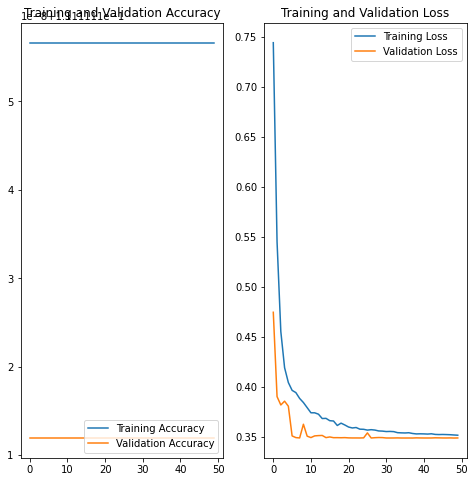

In [44]:
#visualizing the model results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Did you get rid of underfitting/overfitting? Did class rebalance help?

the rebalancing of classes helped to some extent to reduce overfit.
also, batch normalization and augmentation decreased overfitting
